# Market Making Strategy with Cryptocurrencies

In this notebook, I will be implementing the market-making methodology outlined in Avellaneda and Stoikov's popular market making whitepaper titled High-Frequency Trading in a Limit Order Book. The paper can be found for free here: https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

In the whitepaper, the optimal behaviour of a market maker given certain assumptions is derived. Ultimately, this derivation yields a bid/ask spread that is defined as follows:

$$
\text{bid / ask spread} = \gamma \sigma ^2 (T - t) + \frac{2}{\gamma}\ln\left(1 + \frac{\gamma}{k}\right)
$$

This spread is defined around a reservation price i.e. a price at which a market maker is indifferent between their current portfolio and their current portfolio + a new share. The reservation price is derived in the whitepaper as follows:

$$
\text{reservation price} = s - q\gamma\sigma^2(T-t)
$$

The variables mentioned in the above definitions are as follows:

* $s = S_t$ i.e. the per-unit price of an asset at time $t$
* $T$, the terminus of the time series 
* $\sigma$, the volatility of the asset 
* $q$, the number of assets held in inventory
* $\gamma$, a risk factor that is adjusted to meet the risk/return trade-off of the market maker
* $x$, the initial capital of the market maker
* $k$, the intensity of the arrival of orders


# 0 - Implementation of the Paper

Now that we have an idea of where to start, let us first implement the simulation that is done in the paper, and see if we can translate it directly to the crypo pairs that we picked earlier.

In [192]:
#!pip install pykrakenapi
#!pip install binance
#!pip install powerlaw

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sys
import os
from datetime import datetime
import krakenex
from pykrakenapi import KrakenAPI
import binance
import powerlaw
import scipy.optimize

In [34]:
# Create a brownian motion generator
def brownian_motion(x0, n, dt, sigma):

    # Generate normal random variables
    r = np.random.normal(size = n, scale = sigma*np.sqrt(dt))

    # Calculate cumulative sum of random variables
    cumsum = np.cumsum(r)

    # Add in initial conditions
    cumsum += np.expand_dims(x0, axis=-1)
    cumsum[0] = x0
    
    return cumsum

In [44]:
# Set seed for reproducible results
np.random.seed(101)

# Initialize parameters
s0 = 100
T = 1
sigma = 2
dt = 0.005
q0 = 0
gamma = 0.1
k = 1.5
A = 140
sim_length = 1000

In [45]:
spreadlist = []
reslist = []
qlist = []


N = 200

for sim in range(sim_length):
    s = brownian_motion(s0, N+1, dt, sigma)
    
    # Initialize empty array for pnl
    pnl = np.zeros(N+2)
  
    # Inventory
    q = np.zeros(N+2)
    
    # Capital/Cash
    x = np.zeros(N+2)
    
    # Ask limit order
    s_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)
    
    # Bid limit order
    s_b = np.zeros(N+1)

    for i in range(len(s)):
        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)

        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
        
        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        s_a[i] = s[i] + delta_a
        s_b[i] = s[i] - delta_b
        
        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a) * dt
        lambda_b = A*np.exp(-k*delta_b) * dt

        # Restrict to domain of feasible probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell
        
        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]
        
        spreadlist.append(spread * 2)
        
    reslist.append(pnl[-1])
    qlist.append(q[-1])

To ensure that we have correctly implemented the model, our results should be similar to those in the paper:

<img src="img/AS_results.png" alt="Drawing" style="width: 400px;"/>

In [47]:
pd.DataFrame([np.mean(spreadlist), np.mean(resdict), np.std(resdict), np.mean(qlist), np.std(qlist)],
            index=['Avg. Spread','Profit','Std (Profit)', 'Final $q$', 'Std (Final $q$)'],
            columns=['Inventory']).T

Avg. Spread     Profit  Std (Profit)  Final $q$  Std (Final $q$)
Inventory      1.49077  64.683879      6.627999        0.1         2.989314

I believe that these results are sufficiently close to assume that the strategy was implemented properly. Let's take a peek at some visualizations to see what was happening during the simulation.

In [147]:
# Combine all our results into a single DataFrane
res = pd.DataFrame([s_a, s, s_b], index=['sell limit orders', 'mid price', 'buy limit orders']).T

res['sells']  = ((pd.Series(q).diff() > 0)[:-1] * s_a).replace(0,np.nan)
res['buys']   = ((pd.Series(q).diff() < 0)[:-1] * s_b).replace(0,np.nan)

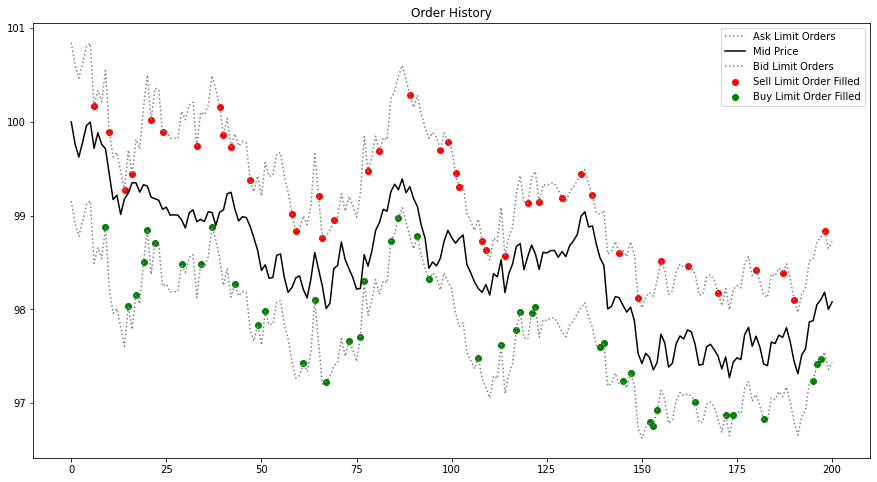

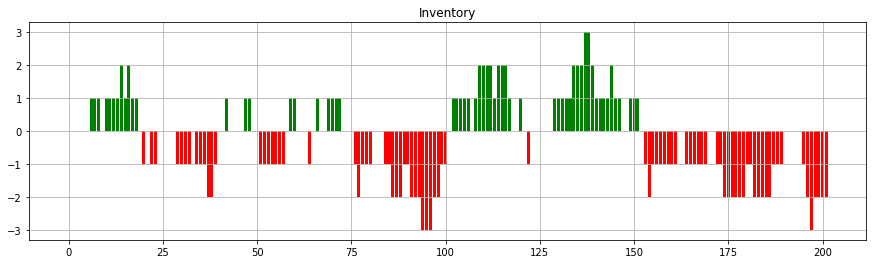

In [151]:
plt.figure(figsize=(15,8))

# Plot limit orders and mid price
plt.plot(res.iloc[:,0], color='grey',  label='Ask Limit Orders', ls=':')
plt.plot(res.iloc[:,1], color='black', label='Mid Price')
plt.plot(res.iloc[:,2], color='grey',  label='Bid Limit Orders', ls=':')

# Add buys and sells
plt.scatter(range(201), res.iloc[:,3], color='red', label='Sell Limit Order Filled')
plt.scatter(range(201), res.iloc[:,4], color='green', label='Buy Limit Order Filled')

plt.legend()
plt.title('Order History')

plt.figure(figsize=(15,4))
plt.grid()
plt.bar(range(len(q)), q*(q>0), color='g')
plt.bar(range(len(q)), q*(q<0), color='r')
plt.title('Inventory')

plt.show()

# 1 - Data

To trade in a limit order book, we must first get order book data. Kraken makes it very easy to download .csv files of their historical order book data, and also provide a REST API. Since there are limitations to the data that can be downloaded via the API, we will first work with the .csv files and if time permits, create an algorithm that extracts the data that we want. 

We will look at two crypto/USD pairs, namely Ethereum/Ether (ETH) and Covalent (CQT). The data for each pair has already been downloaded, so we can easily import them. 

In [316]:
os.listdir('../ETH/')

['ETHUSD.csv',
 'ETHJPY.csv',
 'ETHGBP.csv',
 'ETHXBT.csv',
 'ETHCHF.csv',
 'ETHDAI.csv',
 'ETHUSDT.csv',
 'ETHUSDC.csv',
 'ETHAUD.csv',
 'ETHCAD.csv',
 'ETHEUR.csv']

In [71]:
temp = pd.read_csv('../ETH/ETHUSD.csv', header=None)

In [318]:
temp.head()

0        1          2
0  1438956205  3.00000  70.317378
1  1438956209  3.00000  11.539900
2  1438967962  3.00001   1.073291
3  1438967962  3.00000  41.000000
4  1439016198  3.00000   0.400000

In [319]:
np.shape(temp)

(30917915, 3)

This file is huge (approx. 1GB), and unfortunately, I tried to compress into .h5 and .pkl files, and neither seemed to work too fantastically. In any case, the data is easy to find via Kraken, so recreating this project is very easy.

Now, we know from the Kraken website that the data is formatted as follows:
* Date
* Asset Price
* Volume Exchanged

Let's do a quick sanity check on the data to make sure there aren't any errors:

In [320]:
temp.describe()

0             1             2
count  3.091792e+07  3.091792e+07  3.091792e+07
mean   1.574363e+09  1.132849e+03  4.721387e+00
std    4.702479e+07  1.106889e+03  2.199794e+01
min    1.438956e+09  1.500000e-01  0.000000e+00
25%    1.528041e+09  2.327900e+02  1.000000e-01
50%    1.589193e+09  5.896600e+02  6.659967e-01
75%    1.617857e+09  1.930960e+03  3.000000e+00
max    1.633046e+09  4.380000e+03  6.857221e+03

There shouldn't be any volume values equal to zero unless limit orders are also included in this dataset. Let's take a look:

In [73]:
temp[2][temp[2] == temp[2].min()]

7318103    0.0
7597903    0.0
Name: 2, dtype: float64

Since there are only 2, let's remove these as they don't make any sense (a trade executing but exchanging 0 shares?)

In [74]:
temp = temp[temp[2] != temp[2].min()]

In [75]:
temp.describe()

0             1             2
count  3.091791e+07  3.091791e+07  3.091791e+07
mean   1.574363e+09  1.132849e+03  4.721388e+00
std    4.702479e+07  1.106889e+03  2.199794e+01
min    1.438956e+09  1.500000e-01  1.000000e-08
25%    1.528041e+09  2.327900e+02  1.000000e-01
50%    1.589193e+09  5.896600e+02  6.659968e-01
75%    1.617857e+09  1.930960e+03  3.000000e+00
max    1.633046e+09  4.380000e+03  6.857221e+03

Next, let's take a look at the date range and see if we can spot any problems there:

In [76]:
first_time = temp.iloc[0,0]
last_time = temp.iloc[-1,0]

In [77]:
pd.to_datetime(temp[0],unit='s')#.strftime('%Y-%m-%d %H:%M:%S')

0          2015-08-07 14:03:25
1          2015-08-07 14:03:29
2          2015-08-07 17:19:22
3          2015-08-07 17:19:22
4          2015-08-08 06:43:18
                   ...        
30917910   2021-09-30 23:59:49
30917911   2021-09-30 23:59:49
30917912   2021-09-30 23:59:59
30917913   2021-09-30 23:59:59
30917914   2021-09-30 23:59:59
Name: 0, Length: 30917913, dtype: datetime64[ns]

This is a lot of data, and perhaps we do not need so much immediately to backtest the strategy. Let us first try with a snippet to ensure our algorithm works on this data, and then we can add more data and try to backtest the full strategy. Surely since this data is recorded by the second, there has to be more than one tps. Let's verify this:

In [78]:
temp[temp[0] == last_time]

0        1         2
30917912  1633046399  3000.22  0.179109
30917913  1633046399  3000.22  0.632842
30917914  1633046399  3000.22  0.452355

We can see here that 3 transactions took place at the most recent timestamp. Therefore, we will either need to try to aggregate trades into time-equidistant candles or simply ignore the asynchronous nature of transactions by implementing the infinite-horizon version of Avellaneda-Stoikov and not worrying about time increments. Let's try option 2 first.

In the paper, the opitimizing agent with infinite horizon determines their reserve price and spread according to the following equations:

$$
\begin{aligned}
\bar{r}^a(s,q) &= s + \frac{1}{\gamma}\ln\left(1+ \frac{(1-2q)\gamma^2\sigma^2}{2\omega-\gamma^2q^2\sigma^2}\right)\\
\\
\bar{r}^b(s,q) &= s + \frac{1}{\gamma}\ln\left(1+ \frac{(-1-2q)\gamma^2\sigma^2}{2\omega-\gamma^2q^2\sigma^2}\right)
\end{aligned}
$$

Where this new variable, $\omega$ represents an upper bound to the inventory position we are allowed to take. It is defined as follows:

$$
\omega = \frac{1}{2}\gamma^2\sigma^2(q_\text{max}+1)^2
$$

Where $q_\text{max}$ is the maximum amount of inventory we would like to hold at a single time. Now, this is a number that may need to be solved for, but for now, let's just choose an arbitrary $q_\text{max} = 3$. With this, we will see if we can implement Avellaneda-Stoikov over an infinite horizon:

In [14]:
q_max = 3

omega = 1/2 * gamma**2 * sigma**2 * (q_max + 1)**2

r_a = s[i] + 1/gamma * np.log(1+ ((1-2*q[i])*gamma**2 * sigma**2) / 
                             (2*omega-gamma**2 * q[i]**2 * sigma**2))

r_b = s[i] + 1/gamma * np.log(1+ ((-1-2*q[i])*gamma**2 * sigma**2) / 
                             (2*omega-gamma**2 * q[i]**2 * sigma**2))

r = (r_a + r_b)/2
r_a - r == r - r_b

False

In [15]:
r = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))
spread = spread / 2
spread

0.6453852113757117

In [16]:
resdict = []
N=200
sim_length = 1000

q_max = 5

for sim in range(sim_length):
    s = brownian_motion(s0, N+1, dt, sigma)
    
    # Initialize empty array for pnl
    pnl = np.zeros(N+2)
  
    # Inventory
    q = np.zeros(N+2)
    
    # Capital
    x = np.zeros(N+2)

    # Reserve price
    r = np.zeros(N+1)

    for i in range(len(s)):
        omega = 1/2 * gamma**2 * sigma**2 * (q_max + 1)**2

        r_a = s[i] + 1/gamma * np.log(1+ ((1-2*q[i])*gamma**2 * sigma**2) / 
                                     (2*omega-gamma**2 * q[i]**2 * sigma**2))

        r_b = s[i] + 1/gamma * np.log(1+ ((-1-2*q[i])*gamma**2 * sigma**2) / 
                                     (2*omega-gamma**2 * q[i]**2 * sigma**2))
        
        r[i] = (r_a + r_b)/2
        
        spread = r_a - r[i]

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a)*dt
        lambda_b = A*np.exp(-k*delta_b)*dt

        # Restrict to domain of feasible probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell
        
        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    resdict.append(pnl[-1])

<AxesSubplot:>

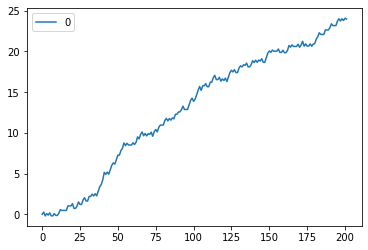

In [17]:
pd.DataFrame(pnl).plot()

Since the above seems to be working quite well for the time-homogenous time series, I feel comfortable moving onto our crypto data.

# Application to Crypto Data

I was able to source 

# Try Finite Time Avellaneda-Stoikov

In [20]:
# Initialize parameters
s0 = 100
N = 60*60*24
T = 1
sigma = 0.3
dt = T/N
q0 = 0
gamma = 0.1
k = 1.5
A = 140
#sim_length = 1000

#s = s.values
    
# Initialize empty array for pnl
pnl = np.zeros(N+2)

# Inventory
q = np.zeros(N+2)

# Capital
x = np.zeros(N+2)

# Reserve price
r = np.zeros(N+1)

for i in range(len(s)):
    r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)

    spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))

    spread = spread / 2

    # Adjust spreads for gap between reserve price
    # and asset mid-price
    gap = np.abs(r[i] - s[i])

    if r[i] >= s[i]:
        delta_a = spread + gap
        delta_b = spread - gap    
    else:
        delta_a = spread - gap
        delta_b = spread + gap

    # Calculate our lambdas, (12)
    lambda_a = A*np.exp(-k*delta_a) * dt
    lambda_b = A*np.exp(-k*delta_b) * dt

    # Restrict to domain of feasible probabilities
    # i.e. [0,1]
    prob_ask = max(0, min(lambda_a,1))
    prob_bid = max(0, min(lambda_b,1))

    # Determine whether or not we buy/sell according
    # to the above probabilities
    sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
    buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

    # Adjust inventory to reflect transactions
    q[i+1] = q[i] + buy - sell

    # Calculate new capital
    x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

    # Calculate pnl of assets
    pnl[i+1] = x[i+1] + q[i+1]*s[i]

resdict.append(pnl[-1])

<AxesSubplot:>

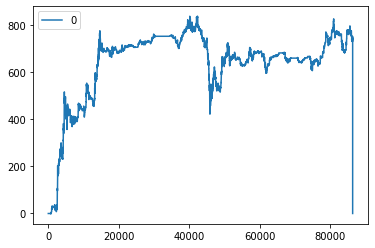

In [21]:
pd.DataFrame(pnl).plot()

Great! Now that we got this to work, let's try estimating some of the parameters. In the end, we will try to update the parameters every day. 

# Estimating $\Lambda$

$\Lambda$ Is one of the values used to calculate A, the coefficient of our Poisson intensity, $\lambda$. In the paper, it is said that $\Lambda$ is a constant frequency of buy or sell orders and it could be **estimated by dividing the total volume traded over a day by the average size of market orders on that day**. This can be easily calculated:

In [79]:
temp = pd.read_csv('../ETH/ETHUSD.csv', header=None)
temp = temp.set_index(0)

In [80]:
temp.index = pd.to_datetime(temp.index,unit='s')
temp.head()

1          2
0                                      
2015-08-07 14:03:25  3.00000  70.317378
2015-08-07 14:03:29  3.00000  11.539900
2015-08-07 17:19:22  3.00001   1.073291
2015-08-07 17:19:22  3.00000  41.000000
2015-08-08 06:43:18  3.00000   0.400000

In [684]:
avg_volume = temp.groupby(pd.Grouper(freq='D'))[2].mean()
avg_volume

0
2015-08-07     30.982642
2015-08-08     97.144407
2015-08-09           NaN
2015-08-10           NaN
2015-08-11    109.935342
                 ...    
2021-09-26      1.302671
2021-09-27      1.428739
2021-09-28      1.868931
2021-09-29      2.062106
2021-09-30      1.952767
Freq: D, Name: 2, Length: 2247, dtype: float64

<AxesSubplot:xlabel='0'>

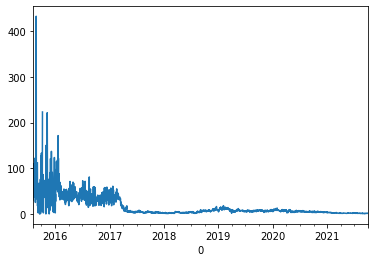

In [685]:
avg_volume.plot()

In [686]:
total_volume = temp.groupby(pd.Grouper(freq='D'))[2].sum()
total_volume

0
2015-08-07      123.930568
2015-08-08     1942.888147
2015-08-09        0.000000
2015-08-10        0.000000
2015-08-11     9234.568705
                  ...     
2021-09-26    30421.271665
2021-09-27    26307.363364
2021-09-28    41079.102185
2021-09-29    38359.295840
2021-09-30    39912.605687
Freq: D, Name: 2, Length: 2247, dtype: float64

<AxesSubplot:xlabel='0'>

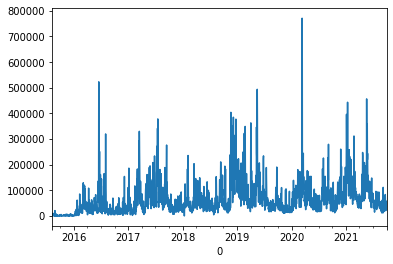

In [687]:
total_volume.plot()

In [688]:
# Fill in any gaps with previous value if no new information
# comes across 
Lambda = (total_volume / avg_volume).ffill()

# Smooth out the function by taking a rolling mean over the 
# past 5 days
Lambda = Lambda.rolling(5).mean()

# Use yesterday's value for today so as to not introduce
# future data
Lambda = Lambda.shift(1)

# First entry should be NaN
Lambda

0
2015-08-07        NaN
2015-08-08        NaN
2015-08-09        NaN
2015-08-10        NaN
2015-08-11        NaN
               ...   
2021-09-26    30595.4
2021-09-27    26062.8
2021-09-28    23672.2
2021-09-29    24117.6
2021-09-30    20079.4
Freq: D, Name: 2, Length: 2247, dtype: float64

<AxesSubplot:xlabel='0'>

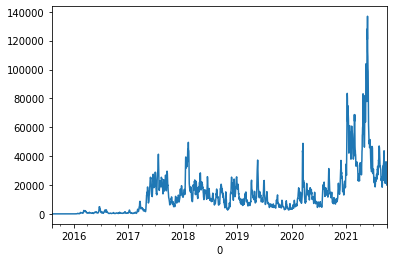

In [834]:
Lambda.plot() 

In [836]:
temp[1].groupby(pd.Grouper(freq='1D')).count()

0
2015-08-07        4
2015-08-08       20
2015-08-09        0
2015-08-10        0
2015-08-11       84
              ...  
2021-09-26    23353
2021-09-27    18413
2021-09-28    21980
2021-09-29    18602
2021-09-30    20439
Freq: D, Name: 1, Length: 2247, dtype: int64

Great, now we have one part of the fraction needed to calculate A, lets move onto the next element:

# Estimating $\alpha$

To do this, we may need to take a peek at another paper in the references titled Statistical Properties of Share Volume Traded in Financial Markets by Gopikrishnan et al. The paper can be viewed here:

https://arxiv.org/pdf/cond-mat/0008113.pdf

Let's pick out a few days and peek at their respective distributions on a log-log scale:

In [690]:
one_day_trades = temp[temp.index.date == datetime(2019, 8, 7).date()][2]

In [691]:
one_day_trades

0
2019-08-07 00:00:00    0.100000
2019-08-07 00:00:04    0.046497
2019-08-07 00:00:04    0.434105
2019-08-07 00:00:25    3.424530
2019-08-07 00:00:25    4.989024
                         ...   
2019-08-07 23:56:53    3.000000
2019-08-07 23:56:53    1.000000
2019-08-07 23:58:39    0.020000
2019-08-07 23:59:14    0.180000
2019-08-07 23:59:15    0.180000
Name: 2, Length: 5454, dtype: float64

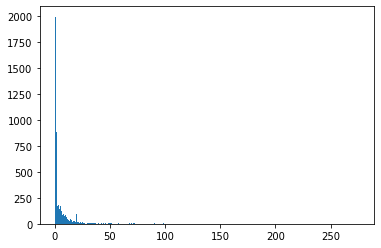

In [692]:
# Linear scale, to be transformed into log scale
hist, bins, _ = plt.hist(one_day_trades.values, bins='auto')
hist, bins = np.histogram(one_day_trades.values, bins='auto')

<AxesSubplot:>

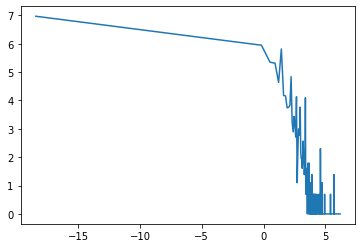

In [629]:
# Show log-log plot to demonstrate power-law distribution
histo = pd.Series(np.log(hist)).replace(-np.inf,0)
histo.index = np.log(bins[:-1])

histo.plot()

In [630]:
# Calculate exponent
powerlaw.Fit(histo).power_law.alpha

5.753626727896894

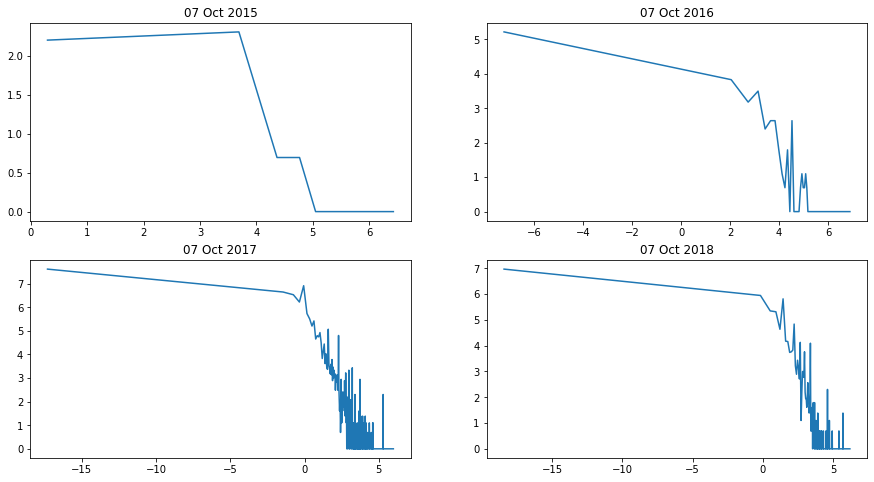

In [639]:
datelist = [datetime(x, 10, 7) for x in range(2015,2019)]
counter = 1

plt.figure(figsize=(15,8))

for day in datelist:
    plt.subplot(2,2,counter)
    plt.title(day.strftime("%d %b %Y"))
    one_day_trades = temp[temp.index.date == day.date()][2]
    hist, bins = np.histogram(one_day_trades.values, bins='auto')
    histo = pd.Series(np.log(hist)).replace(-np.inf,0)
    histo.index = np.log(bins[:-1])
    
    histo.plot()
    counter+=1

In [642]:
date_index = temp.index.date

In [648]:
unique_days = sorted(list(set(date_index)))
unique_days[:5]

[datetime.date(2015, 8, 7),
 datetime.date(2015, 8, 8),
 datetime.date(2015, 8, 11),
 datetime.date(2015, 8, 12),
 datetime.date(2015, 8, 13)]

In [656]:
alphas = []

for day in unique_days:
    locations = date_index == day#.date()
    one_day_trades = temp[locations][2]
    hist, bins = np.histogram(one_day_trades.values, bins='auto')
    histo = pd.Series(np.log(hist)).replace(-np.inf,0)
    alphas.append(powerlaw.Fit(histo).power_law.alpha)

In [729]:
alpha_df = pd.DataFrame(alphas, index=unique_days)

In [730]:
alpha_df = alpha_df.reindex(Lambda.index, method='ffill')

In [749]:
Alist = pd.DataFrame(Lambda.values / alpha_df[0].values, index=Lambda.index).fillna(0)

In [750]:
Alist

0
0                      
2015-08-07     0.000000
2015-08-08     0.000000
2015-08-09     0.000000
2015-08-10     0.000000
2015-08-11     0.000000
...                 ...
2021-09-26  5184.656631
2021-09-27  8246.127623
2021-09-28  7369.864194
2021-09-29  4332.780464
2021-09-30  1913.815565

[2247 rows x 1 columns]

# Finding Optimal $k$

$k$ is calculated as the factor of our $\alpha$ and some market liquidity factor $K$. In the paper, it is written that:

$$
\Lambda P(\Delta p > \delta) = \Lambda P(\ln(\mathcal{Q}) > K\delta)
$$

Using some simple arithmetic, we find that:

$$
K = \frac{\ln(\mathcal{Q})}{\Delta p}
$$

Where $\mathcal{Q}$ is the size of a market order and $\Delta p$ is the price impact of said market order. Using this information, we can estimate a daily value for $K$ and use that in our backtests:

In [361]:
# Calculate avg price change per day
deltap = (temp[1] - temp[1].shift(-1)).groupby(pd.Grouper(freq='1D')).mean().ffill()

lnQ = np.log(temp[2].groupby(pd.Grouper(freq='1D')).mean().ffill())
K = lnQ / deltap
#K * alpha
K = K.replace([np.inf, -np.inf], np.nan).dropna().shift(1)#.mean()

In [362]:
lnQ = np.log(temp[2])


In [363]:
(temp[2].values == temp[2].values.min()).sum()

2

In [364]:
(K * alpha).mean()

192424.87098656403

In [365]:
np.shape(alpha)

(2247,)

In [810]:
klist = K * alpha

In [813]:
klist[klist==klist.max()] = 5

<AxesSubplot:xlabel='0'>

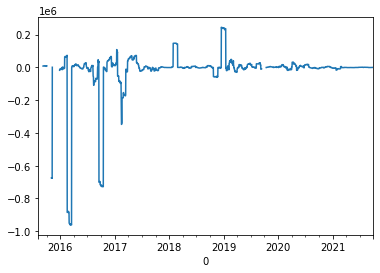

In [814]:
klist.rolling(30).mean().plot()

# Finding Optimal $\gamma$

Let's first try finding the best gamma over the entire time series, then we can go back and use something like yesterday's best gamma to fit today

In [387]:
len(temp.values)

30917915

In [388]:
from multiprocessing import Process, Queue

gammas = np.logspace(-1,1,20)

def print_range(g, que):
    
    N = 60*60*24
    T = 1
    sigma = 0.3
    dt = T/N
    q0 = 0
    gamma = g
    k = 1.5

    # Initialize empty array for pnl
    pnl = np.zeros(N+2)

    # Inventory
    q = np.zeros(N+2)

    # Capital
    x = np.zeros(N+2)

    # Reserve price
    r = np.zeros(N+1)

    for i in range(len(s)):

        # Update daily values if necessary
        A = Alist[Alist.index.date == temp.index[i].date()][0]

        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)

        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))

        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap

        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a) * dt
        lambda_b = A*np.exp(-k*delta_b) * dt

        # Restrict to domain of feasible probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]
    
    que.put(pnl)
    

if __name__ == '__main__':
    queue = Queue()
    for g in range(len(gammas)):
        p = Process(target=print_range, args=(gammas[g], queue,))
        p.start()

#time=np.empty(2,dtype='object')
signal=[]
for g in range(len(gammas)):
    signal.append(queue.get()) # Returns output or blocks until ready
    # Process my output

KeyboardInterrupt: 

<AxesSubplot:>

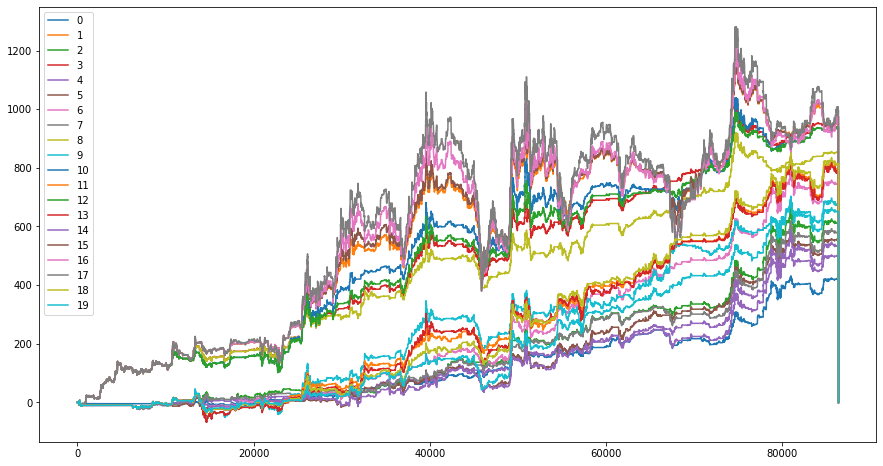

In [44]:
pd.concat([pd.Series(x) for x in signal], axis=1).plot(figsize=(15,8))

In [48]:
sharpes = np.mean(signal, axis=1) / np.std(signal, axis=1)
sharpes

array([0.98246641, 1.81144713, 0.971893  , 1.69909768, 0.94928941,
       0.85746726, 0.96335381, 0.97763633, 1.76092766, 1.10458452,
       1.74047433, 1.02071248, 1.7072897 , 0.99838405, 0.84370884,
       1.82011176, 1.82364984, 1.80452375, 0.9671442 , 0.93863639])

In [49]:
gammas

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

<AxesSubplot:xlabel='Gamma'>

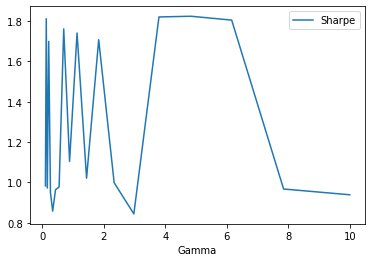

In [50]:
pd.DataFrame([gammas, sharpes], index=['Gamma', 'Sharpe']).T.set_index('Gamma').plot()

The best performing gamma appears to be approx. 3.59:

# Estimating Volatility

$\sigma$ may be a little easier to model. Let's do a rolling 5-day window standard deviation:

<AxesSubplot:xlabel='0'>

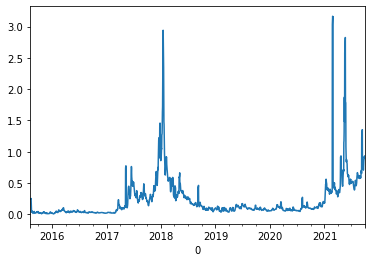

In [494]:
# Calculate avg standard deviation of price changes per day
# Recall that our price is expected to evolve according to a BM with 
# volatility sigma
sigmalist = temp[1].diff().groupby(pd.Grouper(freq='1D')).std().ffill().rolling(5).mean().shift(1)

sigmalist.plot()

# Over Whole Time Series

In [868]:
def print_range(day, g, Alist, sigmalist, k):
    
    N = 60*60*24
    T = 1
    #sigma = 2
    dt = T/N
    q0 = 0
    gamma = g
    #k = 10

    # Initialize empty array for pnl
    pnl = np.zeros(N+2)

    # Inventory
    q = np.zeros(N+2)

    # Capital
    x = np.zeros(N+2)
    
    # Ask limit orders
    r_a = np.zeros(N+1)

    # Reserve price
    r = np.zeros(N+1)
    
    # Bid limit orders
    r_b = np.zeros(N+1)
    
    s = day[1].values
    
    A = Alist#[Alist.index.date == day.index[0]][0][0]
    sigma = sigmalist[sigmalist.index.date == day.index[0]][0]
    #k = 0.00001#k = klist[klist.index.date == day.index[0]][0]

    for i in range(len(s)):

        # Update daily values if necessary
        #A = Alist[Alist.index.date == da.index[i].date()][0]

        r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
        #print(r[i])

        spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))

        spread = spread / 2

        # Adjust spreads for gap between reserve price
        # and asset mid-price
        gap = np.abs(r[i] - s[i])

        if r[i] >= s[i]:
            delta_a = spread + gap
            delta_b = spread - gap    
        else:
            delta_a = spread - gap
            delta_b = spread + gap
            
        r_a[i] = r[i] + delta_a
        r_b[i] = r_b[i] + delta_b

        # Calculate our lambdas, (12)
        lambda_a = A*np.exp(-k*delta_a) * dt
        lambda_b = A*np.exp(-k*delta_b) * dt

        # Restrict to domain of feasible probabilities
        # i.e. [0,1]
        prob_ask = max(0, min(lambda_a,1))
        prob_bid = max(0, min(lambda_b,1))

        # Determine whether or not we buy/sell according
        # to the above probabilities
        sell = np.random.choice([1,0], p=[prob_ask, 1-prob_ask])
        buy  = np.random.choice([1,0], p=[prob_bid, 1-prob_bid])

        # Adjust inventory to reflect transactions
        q[i+1] = q[i] + buy - sell

        # Calculate new capital
        x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

        # Calculate pnl of assets
        pnl[i+1] = x[i+1] + q[i+1]*s[i]
    
    return pnl, r, r_a, r_b

In [869]:
pnldict = {}
rdict = {}
r_adict = {}
r_bdict = {}

start = time.time()
for day_num in range(ndays-10,ndays-1):#range(ndays-1):
    var = s[nsecs*day_num:nsecs*(day_num+1)]
    pnldict[day_num], rdict[day_num], r_adict[day_num], r_bdict[day_num] = print_range(var, 1, 10000, sigmalist, 1.5)
end = time.time()

In [867]:
for i in range(1,len(pnldict.keys())):
    pnldict[list(pnldict.keys())[i]] += pnldict[list(pnldict.keys())[i-1]][-2]

<AxesSubplot:>

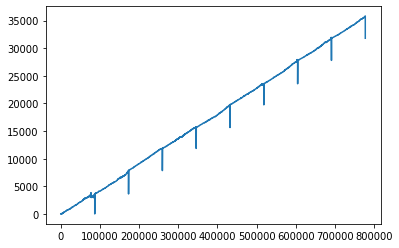

In [847]:
res = pd.concat([pd.Series(x) for x in pnldict.values()], axis=0)
res.index = range(len(res.index))
res.plot()

In [871]:
var['ra'] = r_adict[day_num][:-1]
var['rb'] = r_bdict[day_num][:-1]

<AxesSubplot:xlabel='0'>

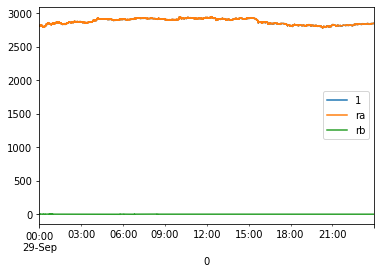

In [872]:
var.plot()

In [863]:
temp

1          2
0                                         
2015-08-07 14:03:25     3.00000  70.317378
2015-08-07 14:03:29     3.00000  11.539900
2015-08-07 17:19:22     3.00001   1.073291
2015-08-07 17:19:22     3.00000  41.000000
2015-08-08 06:43:18     3.00000   0.400000
...                         ...        ...
2021-09-30 23:59:49  2999.79000   0.632842
2021-09-30 23:59:49  2999.79000   0.453733
2021-09-30 23:59:59  3000.22000   0.179109
2021-09-30 23:59:59  3000.22000   0.632842
2021-09-30 23:59:59  3000.22000   0.452355

[30917915 rows x 2 columns]

# Ignore Below Here

Since we will indeed need mid price data i.e. the average of the closest bid and asks, I will need to use the kraken API to fetch these bid/asks. 

In [44]:
api = krakenex.API()
k = KrakenAPI(api)
book = k.get_order_book('XETHZUSD')
df = pd.merge(book[0], book[1], left_index=True, right_index=True)
df = df.rename({"price_x":"Bid Price","volume_x":"Bid Amount", "time_x":"Bid Time",
                "price_y":"Ask Price","volume_y":"Ask Amount", "time_y":"Ask Time"}, axis='columns')
df

Bid Price Bid Amount    Bid Time   Ask Price Ask Amount  \
dtime                                                                           
2021-10-31 01:52:21  4371.86000      0.344  1635645141  4350.45000     57.225   
2021-10-31 01:52:21  4373.64000      0.024  1635645141  4350.45000     57.225   
2021-10-31 01:52:22  4372.04000     45.760  1635645142  4356.69000     14.300   
2021-10-31 01:52:22  4372.04000     45.760  1635645142  4363.47000      0.452   
2021-10-31 01:52:22  4372.04000     45.760  1635645142  4360.73000      4.500   
...                         ...        ...         ...         ...        ...   
2021-10-31 01:53:12  4389.27000    121.141  1635645192  4345.59000     33.019   
2021-10-31 01:53:12  4377.46000     22.713  1635645192  4345.59000     33.019   
2021-10-31 01:53:13  4374.37000      0.354  1635645193  4362.84000      1.958   
2021-10-31 01:53:13  4374.37000      0.354  1635645193  4364.92000     40.035   
2021-10-31 01:53:13  4374.37000      0.354  1635645193  4363.88000      0.458   

                       Ask Time  
dtime                            
2021-10-31 01:52:21  1635645141  
2021-10-31 01:52:21  1635645141  
2021-10-31 01:52:22  1635645142  
2021-10-31 01:52:22  1635645142  
2021-10-31 01:52:22  1635645142  
...                         ...  
2021-10-31 01:53:12  1635645192  
2021-10-31 01:53:12  1635645192  
2021-10-31 01:53:13  1635645193  
2021-10-31 01:53:13  1635645193  
2021-10-31 01:53:13  1635645193  

[117 rows x 6 columns]

This makes things a lot easier. Kraken's endpoint is extremely useful! Let's see how far back we can retrieve the data:

In [25]:
api = krakenex.API()
k = KrakenAPI(api)
book = k.get_order_book('XETHZUSD', count = 10000)
df = pd.merge(book[0], book[1], left_index=True, right_index=True)
df = df.rename({"price_x":"Bid Price","volume_x":"Bid Amount", "time_x":"Bid Time",
                "price_y":"Ask Price","volume_y":"Ask Amount", "time_y":"Ask Time"}, axis='columns')

In [274]:
df

NameError: name 'df' is not defined

In [35]:
import requests

resp = requests.get('https://api.kraken.com/0/public/Depth?pair=XBTUSD&since=1548122302')

print(resp.json())

{'error': [], 'result': {'XXBTZUSD': {'asks': [['62394.30000', '0.036', 1635522861], ['62396.10000', '0.032', 1635522852], ['62400.10000', '0.020', 1635522862], ['62405.00000', '0.065', 1635522862], ['62408.20000', '0.160', 1635522861], ['62408.30000', '1.107', 1635522853], ['62408.40000', '0.401', 1635522861], ['62412.50000', '0.596', 1635522861], ['62412.60000', '0.982', 1635522861], ['62412.70000', '1.094', 1635522853], ['62413.10000', '4.007', 1635522861], ['62415.60000', '1.200', 1635522846], ['62416.50000', '1.839', 1635522862], ['62417.20000', '0.641', 1635522861], ['62419.80000', '0.251', 1635522853], ['62422.00000', '0.126', 1635522853], ['62423.50000', '0.674', 1635522861], ['62424.90000', '0.034', 1635522861], ['62426.20000', '0.025', 1635522838], ['62427.40000', '3.209', 1635522824], ['62431.10000', '0.018', 1635522861], ['62433.20000', '0.205', 1635522828], ['62439.00000', '3.206', 1635522857], ['62439.50000', '0.017', 1635522861], ['62443.20000', '0.058', 1635522861], ['6

In [52]:
datetime.utcfromtimestamp(1635522801)

datetime.datetime(2021, 10, 29, 15, 53, 21)

In [53]:
import websocket

In [19]:
[x for x in sorted(binance.tickers().keys()) if 'ETH' in x]

['AAVEETH',
 'ADAETH',
 'ADXETH',
 'AEETH',
 'AGIETH',
 'AIONETH',
 'AMBETH',
 'APPCETH',
 'ARDRETH',
 'ARKETH',
 'ARNETH',
 'ASTETH',
 'AXSETH',
 'BATETH',
 'BCCETH',
 'BCDETH',
 'BCNETH',
 'BCPTETH',
 'BETHETH',
 'BLZETH',
 'BNBETH',
 'BNTETH',
 'BQXETH',
 'BRDETH',
 'BTGETH',
 'BTSETH',
 'CDTETH',
 'CHATETH',
 'CLOAKETH',
 'CMTETH',
 'CNDETH',
 'COVERETH',
 'CVCETH',
 'CVPETH',
 'DASHETH',
 'DATAETH',
 'DENTETH',
 'DEXEETH',
 'DFETH',
 'DGDETH',
 'DLTETH',
 'DNTETH',
 'DOCKETH',
 'EASYETH',
 'EDOETH',
 'ELFETH',
 'ENGETH',
 'ENJETH',
 'EOSETH',
 'ETCETH',
 'ETHAUD',
 'ETHBEARBUSD',
 'ETHBEARUSDT',
 'ETHBIDR',
 'ETHBKRW',
 'ETHBRL',
 'ETHBTC',
 'ETHBULLBUSD',
 'ETHBULLUSDT',
 'ETHBUSD',
 'ETHDAI',
 'ETHDOWNUSDT',
 'ETHEUR',
 'ETHGBP',
 'ETHNGN',
 'ETHPAX',
 'ETHRUB',
 'ETHTRY',
 'ETHTUSD',
 'ETHUAH',
 'ETHUPUSDT',
 'ETHUSDC',
 'ETHUSDP',
 'ETHUSDT',
 'ETHZAR',
 'EVXETH',
 'EZETH',
 'FIROETH',
 'FRONTETH',
 'FTMETH',
 'FUELETH',
 'FUNETH',
 'GHSTETH',
 'GLMETH',
 'GNTETH',
 'GRSETH',


In [849]:
!pip install cbpro

In [850]:
from cbpro.public_client import PublicClient

In [46]:
client = PublicClient()
ob_all = client.get_product_order_book('ETH-USD', 1)

NameError: name 'PublicClient' is not defined

In [47]:
ob_all

NameError: name 'ob_all' is not defined

# ETH Order Book Data

I found order book data here: https://www.kaggle.com/martinsn/starter-high-frequency-bitcoin-forecasting

In [50]:
os.listdir('../archive')

['BTC_1min.csv',
 'ETH_5min.csv',
 'ADA_1sec.csv',
 'ETH_1min.csv',
 'BTC_5min.csv',
 'BTC_1sec.csv',
 'ADA_1min.csv',
 'ADA_5min.csv',
 'ETH_1sec.csv']

In [67]:
ETH_mid = pd.read_csv('../archive/ETH_1sec.csv')
ETH_mid.head()

Unnamed: 0                       system_time  midpoint  spread  \
0           0  2021-04-07 11:32:50.861733+00:00  1970.985    0.15   
1           1  2021-04-07 11:32:51.861733+00:00  1970.985    0.15   
2           2  2021-04-07 11:32:52.861733+00:00  1970.985    0.15   
3           3  2021-04-07 11:32:53.861733+00:00  1970.985    0.15   
4           4  2021-04-07 11:32:54.861733+00:00  1971.135    0.03   

          buys     sells  bids_distance_0  bids_distance_1  bids_distance_2  \
0     0.000000  0.000000        -0.000038        -0.000495        -0.000500   
1     0.000000  0.000000        -0.000038        -0.000495        -0.000500   
2     0.000000  0.000000        -0.000038        -0.000495        -0.000500   
3     0.000000  0.000000        -0.000038        -0.000495        -0.000500   
4  5832.007602  1.962869        -0.000008        -0.000571        -0.000576   

   bids_distance_3  ...  asks_market_notional_5  asks_market_notional_6  \
0        -0.000632  ...                     0.0                     0.0   
1        -0.000632  ...                     0.0                     0.0   
2        -0.000632  ...                     0.0                     0.0   
3        -0.000632  ...                     0.0                     0.0   
4        -0.000601  ...                     0.0                     0.0   

   asks_market_notional_7  asks_market_notional_8  asks_market_notional_9  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   asks_market_notional_10  asks_market_notional_11  asks_market_notional_12  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   asks_market_notional_13  asks_market_notional_14  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      0.0                      0.0  
3                      0.0                      0.0  
4                      0.0                      0.0  

[5 rows x 156 columns]

In [68]:
ETH_mid['system_time'] = pd.to_datetime(ETH_mid['system_time'])
ETH_mid = ETH_mid.loc[:,['system_time', 'midpoint']]

In [69]:
ETH_mid = ETH_mid.set_index('system_time')
ETH_mid

midpoint
system_time                               
2021-04-07 11:32:50.861733+00:00  1970.985
2021-04-07 11:32:51.861733+00:00  1970.985
2021-04-07 11:32:52.861733+00:00  1970.985
2021-04-07 11:32:53.861733+00:00  1970.985
2021-04-07 11:32:54.861733+00:00  1971.135
...                                    ...
2021-04-19 09:53:42.345392+00:00  2237.005
2021-04-19 09:53:43.345392+00:00  2237.290
2021-04-19 09:53:44.345392+00:00  2236.430
2021-04-19 09:53:45.345392+00:00  2236.225
2021-04-19 09:53:46.345392+00:00  2236.280

[1030775 rows x 1 columns]

Now, this may not be completely proper, but for the sake of this project, I will need to remove the miliseconds in order for the data to properly align with the Kraken dataset. Under normal circumstances this would be bad to do. 

In [98]:
ETH_mid.index = ETH_mid.index.strftime('%Y-%m-%d %H:%M:%S')
ETH_mid.head()

midpoint
system_time                  
2021-04-07 11:32:50  1970.985
2021-04-07 11:32:51  1970.985
2021-04-07 11:32:52  1970.985
2021-04-07 11:32:53  1970.985
2021-04-07 11:32:54  1971.135

In [118]:
dates = pd.to_datetime(ETH_mid.index) 

In [129]:
# Split data into train and test data
length = len(ETH_mid)
train = ETH_mid.iloc[:int(length*0.7),:]
test = ETH_mid.iloc[int(length*0.7):,:]

In [138]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

# Assume All Orders Get Filled

First, we will skip the depth of the order book and assume that all of our orders get filled by a market order (i.e. there is enough depth and our limit orders get filled first). Once we have that built out, if time permits, then we can go into a more sophisticated estimation method. 

Recall that we want to estimate the parameters $A$ and $\kappa$ for our market intensity parameters, $\lambda_{a,b}$ i.e.

$$
\lambda(\delta) = A e^{-\kappa\delta}
$$

To assist us with this parameters estimation, we will be following the method outlined by Sophie Laruelle's paper which can be found here: http://events.chairefdd.org/wp-content/uploads/2013/06/CAHIER_MICRO_1.pdf , as well as a very well-written stackexchange post by Charles-Albert Lehalle found here: https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem

In [141]:
# Slice one day first 
sample = train.loc['2021-04-07']
sample.tail()

midpoint
system_time                  
2021-04-07 23:59:55  1962.855
2021-04-07 23:59:56  1963.525
2021-04-07 23:59:57  1964.305
2021-04-07 23:59:58  1963.950
2021-04-07 23:59:59  1963.550

In [143]:
deltalist = np.linspace(0.1,1,10)

sample['bids'] = sample['midpoint'] - deltalist[0]
sample['ask']  = sample['midpoint'] + deltalist[0]

In [144]:
sample

midpoint      bids       ask
system_time                                      
2021-04-07 11:32:50  1970.985  1970.885  1971.085
2021-04-07 11:32:51  1970.985  1970.885  1971.085
2021-04-07 11:32:52  1970.985  1970.885  1971.085
2021-04-07 11:32:53  1970.985  1970.885  1971.085
2021-04-07 11:32:54  1971.135  1971.035  1971.235
...                       ...       ...       ...
2021-04-07 23:59:55  1962.855  1962.755  1962.955
2021-04-07 23:59:56  1963.525  1963.425  1963.625
2021-04-07 23:59:57  1964.305  1964.205  1964.405
2021-04-07 23:59:58  1963.950  1963.850  1964.050
2021-04-07 23:59:59  1963.550  1963.450  1963.650

[44817 rows x 3 columns]

In [166]:
mkt_sample = temp.loc['2021-04-07']
mkt_sample = mkt_sample.iloc[-3:-1,:]

In [181]:
mkt_sample

1    2
0                                
2021-04-07 23:59:49  1960.17  0.5
2021-04-07 23:59:49  1961.06  4.5

In [182]:
sample.loc[mkt_sample.index]

midpoint      bids       ask
0                                                
2021-04-07 23:59:49  1960.195  1960.095  1960.295
2021-04-07 23:59:49  1960.195  1960.095  1960.295

In [184]:
# Only need the minimum value for each 1s interval to determine if 
# a market order filled
mkt_sample[1].groupby(pd.Grouper(freq='1S')).apply(lambda x: any(x > sample.loc[x.name, 'ask']))

0
2021-04-07 23:59:49    True
Freq: S, Name: 1, dtype: bool

In [204]:
mkt_sample = temp.loc[sample.index[0]:sample.index[-1]]
mkt_sample.index

DatetimeIndex(['2021-04-07 11:32:50', '2021-04-07 11:32:51',
               '2021-04-07 11:32:51', '2021-04-07 11:32:52',
               '2021-04-07 11:32:52', '2021-04-07 11:32:55',
               '2021-04-07 11:32:56', '2021-04-07 11:32:56',
               '2021-04-07 11:32:56', '2021-04-07 11:32:56',
               ...
               '2021-04-07 23:59:46', '2021-04-07 23:59:46',
               '2021-04-07 23:59:46', '2021-04-07 23:59:46',
               '2021-04-07 23:59:47', '2021-04-07 23:59:47',
               '2021-04-07 23:59:47', '2021-04-07 23:59:49',
               '2021-04-07 23:59:49', '2021-04-07 23:59:52'],
              dtype='datetime64[ns]', name=0, length=33009, freq=None)

In [215]:
# There seems to be some missing data...
(sample.index == '2021-04-07 16:00:00').sum()

0

In [241]:
sample = sample.resample('S').asfreq(fill_value=np.nan)

In [242]:
# Ensure that 

In [243]:
# Do this for all
bid_limit_order_hit = mkt_sample[1].groupby(pd.Grouper(freq='1S')).apply(lambda x: any(x < sample.loc[x.name, 'bids']))
ask_limit_order_hit = mkt_sample[1].groupby(pd.Grouper(freq='1S')).apply(lambda x: any(x > sample.loc[x.name, 'ask']))

In [245]:
bid_limit_order_hit

0
2021-04-07 11:32:50     True
2021-04-07 11:32:51     True
2021-04-07 11:32:52     True
2021-04-07 11:32:53    False
2021-04-07 11:32:54    False
                       ...  
2021-04-07 23:59:48    False
2021-04-07 23:59:49    False
2021-04-07 23:59:50    False
2021-04-07 23:59:51    False
2021-04-07 23:59:52     True
Freq: S, Name: 1, Length: 44823, dtype: bool

In [253]:
# Combine the two into a single signal
limit_order_hit = bid_limit_order_hit | ask_limit_order_hit

In [255]:
# Sanity check
limit_order_hit.sum() > bid_limit_order_hit.sum()

True

In [256]:
# Sanity check
limit_order_hit.sum() > ask_limit_order_hit.sum()

True

Calculate the duration it takes for a market order to fill a limit order:

In [297]:
deltas01 = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())

We know that the maximum likelihood estimator of $\lambda$ for a Poisson distribution is the sample mean therefore:

In [299]:
deltas01#ly(lambda x: x.total_seconds())

0        NaN
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
10041    2.0
10042    2.0
10043    1.0
10044    2.0
10045    3.0
Name: 0, Length: 10046, dtype: float64

In [477]:
np.mean(deltas01)

3150.285714285714

In [490]:
sample['midpoint']

system_time
2021-04-07 11:32:50    1970.985
2021-04-07 11:32:51    1970.985
2021-04-07 11:32:52    1970.985
2021-04-07 11:32:53    1970.985
2021-04-07 11:32:54    1971.135
                         ...   
2021-04-07 23:59:55    1962.855
2021-04-07 23:59:56    1963.525
2021-04-07 23:59:57    1964.305
2021-04-07 23:59:58    1963.950
2021-04-07 23:59:59    1963.550
Freq: S, Name: midpoint, Length: 44830, dtype: float64

Now, let's extend this to each value in our deltalist:

In [575]:
deltalist = np.linspace(0.1,1,10)
deltadict = {}

for price_delta in deltalist:
    print(price_delta)
    sample['bids'] = sample['midpoint'] - price_delta
    sample['ask']  = sample['midpoint'] + price_delta
    
    bid_limit_order_hit = mkt_sample[1].groupby(pd.Grouper(freq='1S')).apply(lambda x: any(x < sample.loc[x.name, 'bids']))
    ask_limit_order_hit = mkt_sample[1].groupby(pd.Grouper(freq='1S')).apply(lambda x: any(x > sample.loc[x.name, 'ask']))
    
    # Combine the two into a single signal
    limit_order_hit = bid_limit_order_hit | ask_limit_order_hit
    
    deltas01 = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x.total_seconds())
    
    deltadict[price_delta] = deltas01

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


In [576]:
def exp_fit(x,a,b):
    y = a*np.exp(-b*x)
    return y

In [577]:
1/deltadict[0.1].mean()

0.22410869662219443

<AxesSubplot:xlabel='0'>

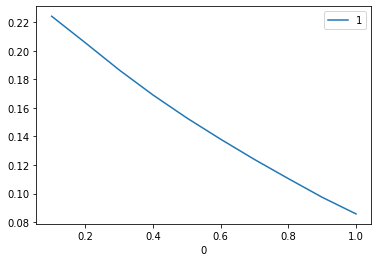

In [578]:
lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()]).set_index(0)
lambdas.plot()

In [579]:
paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas[1].values))
a, b = paramsB

Text(0.5, 1.0, 'Fitted Exponential Curve')

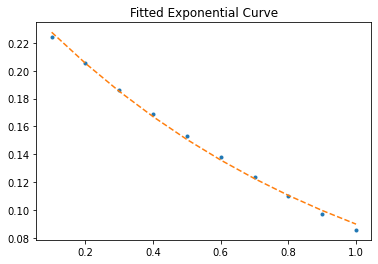

In [581]:
plt.plot(np.array(lambdas.index), np.array(lambdas[1].values), '.', label="data")
plt.plot(np.array(lambdas.index), exp_fit(np.array(lambdas.index), a, b), '--', label="fitted")
plt.title("Fitted Exponential Curve")

In [583]:
a * b

0.2602008010592739

In [585]:
a*np.exp(-b*0.1)

0.22756146490065415

In [706]:
mkt_sample[1].pct_change().std()*np.sqrt(N)

0.054845130096152814

In [597]:
ETH_mid.index

Index(['2021-04-07 11:32:50', '2021-04-07 11:32:51', '2021-04-07 11:32:52',
       '2021-04-07 11:32:53', '2021-04-07 11:32:54', '2021-04-07 11:32:55',
       '2021-04-07 11:32:56', '2021-04-07 11:32:57', '2021-04-07 11:32:58',
       '2021-04-07 11:32:59',
       ...
       '2021-04-19 09:53:37', '2021-04-19 09:53:38', '2021-04-19 09:53:39',
       '2021-04-19 09:53:40', '2021-04-19 09:53:41', '2021-04-19 09:53:42',
       '2021-04-19 09:53:43', '2021-04-19 09:53:44', '2021-04-19 09:53:45',
       '2021-04-19 09:53:46'],
      dtype='object', name='system_time', length=1030775)

In [750]:
#sigma
log_norm = np.log(mkt_sample[1]).diff(1).dropna()

In [799]:
log_norm.std() * np.sqrt(N)

0.05484364831874166

In [801]:
a < np.nan

False

# Use Parameters for Next Day

In [829]:
# Get mid prices for next day
s = train.loc['2021-04-08']
s = s.resample('S').asfreq(fill_value=np.nan)
s = s.ffill()
s = s['midpoint'] 

# Get market orders for next day, low market is lowest
# price of market order submitted in 1-sec
low_mkt = temp.loc['2021-04-08'].resample('S').min().reindex(s.index)

# hi market is highest price of market order submitted
# in 1-sec
hi_mkt = temp.loc['2021-04-08'].resample('S').max().reindex(s.index)

In [834]:
N = 60*60*24
T = 1
sigma = 0.0548#1064#np.std(mkt_sample[1]) / np.sqrt(N)
dt = T/N
q0 = 0
gamma = 0.1
A = a# * 33009
k = b# * a

# Initialize empty array for pnl
pnl = np.zeros(N+2)

# Inventory
q = np.zeros(N+2)

# Capital
x = np.zeros(N+2)

# Ask limit orders
r_a = np.zeros(N+1)

# Reserve price
r = np.zeros(N+1)

# Bid limit orders
r_b = np.zeros(N+1)

for i in range(len(s)):
    date = s.index[i]

    # Update daily values if necessary
    #A = Alist[Alist.index.date == da.index[i].date()][0]

    r[i] = s[i] - q[i] * gamma * sigma**2 * (T-i*dt)
    #print(r[i])

    spread = gamma * sigma**2 * (T - i * dt) + (2 / gamma) * np.log(1 + (gamma / k))

    spread = spread / 2

    # Adjust spreads for gap between reserve price
    # and asset mid-price
    gap = np.abs(r[i] - s[i])

    if r[i] >= s[i]:
        delta_a = spread + gap
        delta_b = spread - gap    
    else:
        delta_a = spread - gap
        delta_b = spread + gap

    r_a[i] = r[i] + delta_a
    r_b[i] = r[i] - delta_b
    
    sell = 0
    buy  = 0
    
    if hi_mkt.loc[date,1] > r_a[i]:
        sell = 0.1
    
    if low_mkt.loc[date,1] < r_b[i]:
        buy = 0.1

    # Adjust inventory to reflect transactions
    q[i+1] = q[i] + buy - sell

    #     # Calculate new capital
    x[i+1] = x[i] + sell*(s[i]+delta_a) - buy*(s[i]-delta_b)

    #     # Calculate pnl of assets
    pnl[i+1] = x[i+1] + q[i+1]*s[i]


<AxesSubplot:>

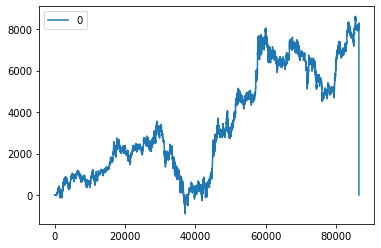

In [835]:
pd.DataFrame(pnl).plot()

In [784]:
r_df = pd.DataFrame(np.array([r_a[:-2], r_b[:-2]]), columns=s.index).T
r_df

0            1
system_time                                  
2021-04-08 00:00:01  1965.365556  1963.514444
2021-04-08 00:00:02  1965.365556  1963.514444
2021-04-08 00:00:03  1965.365556  1963.514444
2021-04-08 00:00:04  1965.365556  1963.514444
2021-04-08 00:00:05  1965.365556  1963.514444
...                          ...          ...
2021-04-08 23:59:55  2082.130406  2080.279594
2021-04-08 23:59:56  2082.130406  2080.279594
2021-04-08 23:59:57  2082.110406  2080.259594
2021-04-08 23:59:58  2082.400406  2080.549594
2021-04-08 23:59:59  2082.220406  2080.369594

[86399 rows x 2 columns]

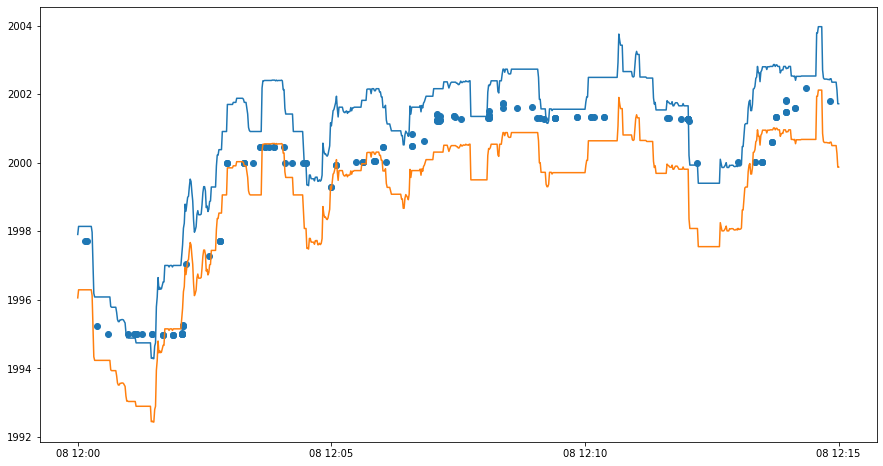

In [788]:
start = '2021-04-08 12:00:00'
end = '2021-04-08 12:15:00'

plt.figure(figsize=(15,8))
plt.scatter(temp.loc[start:end][1].index, temp.loc[start:end][1].values)
plt.plot(r_df.loc[start:end])